In [42]:
###
###  FIXME: This code can not be run 
###
import h5py as h5
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
    
import os
import time
from datetime import datetime
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle

N_DIGITS = 1
X_FEATURE = 'x'  # Name of the input feature.

RATE = 8192
BATCH = 256
EPOCHS = 300

class StoppingLossHook(tf.train.SessionRunHook):
    def __init__(self, monitor, eps=0.01, patience=5, max=10000):
        self.monitor = monitor
        self.eps = eps
        self.patience = patience
        self.wait = 0
        self.max = max

    def begin(self):
        # Convert names to tensors if given
        graph = tf.get_default_graph()
        self.monitor = graph.as_graph_element(self.monitor)
        self.iter = 0
        if isinstance(self.monitor, tf.Operation):
            self.monitor = self.monitor.outputs[0]

    def before_run(self, run_context):  # pylint: disable=unused-argument
        return tf.train.SessionRunArgs(self.monitor)

    def after_run(self, run_context, run_values):
        self.iter += 1

        if self.iter>self.max: run_context.request_stop()  

        if run_values.results > self.eps:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                run_context.request_stop()  
                
class LoggerHook(tf.train.SessionRunHook):
    def __init__(self, monitor, interval=100):
        self.monitor = monitor
        self.interval = interval

    def begin(self):
        self._step = -1
        self._start_time = time.time()

        # Convert names to tensors if given
        graph = tf.get_default_graph()
        self.monitor = graph.as_graph_element(self.monitor)
        if isinstance(self.monitor, tf.Operation):
            self.monitor = self.monitor.outputs[0]

    def before_run(self, run_context):
        self._step += 1
        return tf.train.SessionRunArgs(self.monitor)

    def after_run(self, run_context, run_values):
        if self._step % self.interval == 0:

            res = run_values.results

            current_time = time.time()
            duration = current_time - self._start_time
            self._start_time = current_time

            # sample / second
            examples_per_sec = self.interval * BATCH / duration
            # time / batch
            sec_per_batch = float(duration / self.interval)
            format_str = ('Step: %4d, loss: %.2g  ( %.1f examples/sec; %.1f sec/batch)')
            print(format_str % (self._step, res, examples_per_sec, sec_per_batch))


####
####   Network architecture
####
def conv_model(features, labels, mode):
  print ("-------- Initial model for ", mode)
  feature = tf.reshape(features[X_FEATURE], [-1, RATE,1])
  with tf.variable_scope('conv_layer1'):
    h_conv1 = tf.layers.conv1d(feature, filters=16, kernel_size=[16], padding='same', activation=tf.nn.relu)
    h_pool1 = tf.layers.max_pooling1d(h_conv1, pool_size=4, strides=4, padding='same', name='p1')
  with tf.variable_scope('conv_layer2'):
    h_conv2 = tf.layers.conv1d(h_pool1, filters=32, kernel_size=[8], padding='same', activation=tf.nn.relu)
    h_pool2 = tf.layers.max_pooling1d(h_conv2, pool_size=4, strides=4, padding='same', name='p2')
    #h_pool2 = tf.layers.batch_normalization(h_pool2n)
  with tf.variable_scope('conv_layer3'):
    h_conv3 = tf.layers.conv1d(h_pool2, filters=64, kernel_size=[8], padding='same', activation=tf.nn.relu)
    h_pool3 = tf.layers.max_pooling1d(h_conv3, pool_size=4, strides=4, padding='same', name='p3')
    #h_pool3 = tf.layers.batch_normalization(h_pool3n)
    
    dim = h_pool3.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    h_pool3_flat = tf.reshape(h_pool3, [-1, fcnn])   ## linearize the matrix into 1D vector, =64*119
    #print ("================ P3F: ", mode, h_pool3_flat.get_shape())

  # Densely connected layer
  h_fc1 = tf.layers.dense(h_pool3_flat, 64, activation=tf.nn.relu, name='d1')
  ### if mode == tf.estimator.ModeKeys.TRAIN: h_fc1 = tf.layers.dropout(h_fc1, rate=0.5)   ## dropout not used by Huerta

  ### 1-output  
  logits = tf.layers.dense(h_fc1, N_DIGITS, activation=None, name='d2')   ## No activation
  #print ("================ logits: ", mode, logits.get_shape())

  # Compute predictions
   
  predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
  predict_op   = tf.round(predict_prob)  ## return largest index

  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        'class': predict_op,
        'prob': predict_prob
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Create training op.
  loss = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=labels)
  #print ("================ loss: ", mode, loss.get_shape())

    
    
  if mode == tf.estimator.ModeKeys.TRAIN:
    
    #learning_rate = tf.train.exponential_decay(0.05, tf.train.get_global_step(), decay_steps=2000, decay_rate=0.95, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    train_op  = optimizer.minimize(loss, global_step=tf.train.get_global_step())

    #logger_hook    = LoggerHook(monitor=loss,          interval=50)
    #logger_hook2   = LoggerHook(monitor=learning_rate, interval=100)
    stopping_hook = StoppingLossHook(monitor=loss, eps=1e-2, max=9999)
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op, training_hooks=[stopping_hook])

  # Compute evaluation metrics.
  eval_metric_ops = {
      #'accuracy':  tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=labels)
      'accuracy': tf.metrics.accuracy(labels=labels, predictions=predict_op  ),
      'sensitivity': tf.metrics.recall(labels=labels, predictions=predict_op  )
  }
  return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)

def prepare_data(SNR):

    """
    f = h5.File("signal_15.h5", "r")
    print ("Load data with smpling rate = ", f.attrs.get('srate') )
    x = f['/signal']
    n = f['/noise']
    m1 = f['/m1']
    m2 = f['/m2']
    
    X      = np.vstack((x,n)).astype(np.float32)
    y      = np.zeros(NX+NN)
    y[:NX] = np.ones(NX)
    y      = y.astype(np.float32).reshape(-1,1)

    """
    f = h5.File("white_h.h5", "r")
    rate = f.attrs.get('srate')
    print ("Load data with smpling rate = ", rate )
    x_train = f['/train']
    #m1 = f['/train_m1']
    #m2 = f['/train_m2']
    x_test = f['/test']
    #m1 = f['/test_m1']
    #m2 = f['/test_m2']

    ##########
    NX=len(x_train)
    print ("==== SNR  RATE NX  x[1,1] ===================", SNR, RATE, NX, x_train[1,1])
    X_train      = (x_train[:,:]*SNR+np.random.normal(0,1,(NX,RATE))).astype(np.float32)

    NN=NX
    X_train      = np.vstack((X_train, np.random.normal(0,1,(NN,RATE))   )).astype(np.float32)
    y_train      = np.hstack((np.ones(NX), np.zeros(NN) )).astype(np.float32).reshape(-1,1)
    print ("******* EPOCHS: %d, BATCH: %d, Step: %f " % (EPOCHS, BATCH, 30*(NN+NX)/BATCH    ) )
    
    ###########
    NX=len(x_test)
    print ("==== SNR RATE NX  x[1,1] ===================", SNR, RATE, NX, x_test[1,1])
    X_test      = (x_test[:,:]*SNR+np.random.normal(0,1,(NX,RATE))).astype(np.float32)

    NN=NX
    X_test      = np.vstack((X_test, np.random.normal(0,1,(NN,RATE))   )).astype(np.float32)
    y_test      = np.hstack((np.ones(NX), np.zeros(NN) )).astype(np.float32).reshape(-1,1)
    print ("******* EPOCHS: %d, BATCH: %d, Step: %f " % (EPOCHS, BATCH, 30*(NN+NX)/BATCH    ) )

    f.close()
    #train_test_split(X, y, test_size=0.2, shuffle=True, random_state=None) 
    
    Xt, Yt = shuffle(X_train, y_train)
    Xs, Ys = shuffle(X_test, y_test)
    if 0:
        plt.figure()
        plt.plot(Xt[1,:])
        plt.plot(Xt[2,:])
        plt.show()
    
    return Xt, Xs, Yt, Ys 

##
##  SNR = ratio of max(w_h)/max(w_noise)
##
def CNN(SNR):
    tf.logging.set_verbosity(tf.logging.INFO)
    #tf.logging.set_verbosity(tf.logging.WARN)
    
    X_train, X_test, y_train, y_test = prepare_data(SNR)

    ### Download and load MNIST dataset.##mnist = tf.contrib.learn.datasets.DATASETS['mnist']('/tmp/mnist')
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = { X_FEATURE: X_train },  y = y_train,
        batch_size = BATCH,  ### step = N / Batch * epoches
        num_epochs = EPOCHS,  shuffle=True)
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = { X_FEATURE: X_test },   y= y_test,
        #batch_size = None,
        num_epochs=1,   shuffle=False)

    ########## CNN
    #try: os.remove('/tmp/tf_lin/checkpoint')  
    #except OSError: pass

    config = tf.contrib.learn.RunConfig(
        save_checkpoints_steps=10000000000,  ## at 1 and last
        save_checkpoints_secs=None,
        save_summary_steps=None,
        #gpu_memory_fraction=0.5,
        model_dir='/tmp/tf_lin'
    )
    classifier = tf.estimator.Estimator(model_fn=conv_model, config=config)
    #tensors_to_log = {"out_sigmoid": "sigmoid_tensor"}
    
    classifier.train(input_fn=train_input_fn, steps=None)
    #classifier.export_savedmodel('/tmp/tf_lin/saved', serving_input_receiver_fn=train_input_fn, strip_default_attrs=True)
    
    
    scores = classifier.evaluate(input_fn=test_input_fn, steps=None)
    
    if 0:
        prediction = classifier.predict(input_fn=test_input_fn)
        i=0
        FP=0
        FN=0
        TP=0
        TN=0
        CE=0
        for p in prediction: 
            print (y_test[i], p)
            #print (y_test[i], p['class'])
            
            if (y_test[i]==1 and p['class']==1): TP=TP+1
            if (y_test[i]==1 and p['class']==0): FP=FP+1
            if (y_test[i]==0 and p['class']==1): FN=FN+1
            if (y_test[i]==0 and p['class']==0): TN=TN+1
            CE=y_test[i]*np.log(p['prob'])
            i = i+1
            
        print ("TP", TP)
        print ("TN", TN)
        print ("FP", FP)
        print ("FN", FN)
        print ("Accuracy:", (TN+TP)/float(i) )
        print ("Recall  :", (TP)/(TP+FP)  )
        print ("CE      :", CE  )
            
    
    print(scores)  
    return scores['loss'], scores['accuracy'], scores['sensitivity']


    if 0:  
        ######### Linear classifier.
        feature_columns = [ tf.feature_column.numeric_column(X_FEATURE, shape=RATE) ]

        classifier = tf.estimator.LinearClassifier(feature_columns = feature_columns, n_classes=N_DIGITS)
        classifier.train(input_fn=train_input_fn, steps=None)
        scores = classifier.evaluate(input_fn=test_input_fn, steps=None)
        print("+++++ LC: ", scores)

    
gloss = []
gacc  = []
gsen  = []
gstep = []


def main(unused):
    
    try: os.remove('/tmp/tf_lin/checkpoint')  
    except OSError: pass

    #saver = tf.train.Saver()
    
    #snr = [0.075,0.05,0.025, 0.02, 0.01, 0.005, 0.003, 0.002, 0.001,  0.0001]
    snr = [0.8, 0.6, 0.5, 0.4, 0.3,0.25,0.2,0.15, 0.1,0.05]
    for i in snr:
        l, a, s = CNN(i)
        gloss.append(l)
        gacc.append(a)
        gsen.append(s)
        gstep.append(tf.train.get_global_step())
    print("Loss  :", gloss)
    print("Acc   :", gacc)
    print("Recall:", gsen)
        
if __name__ == '__main__':
  tf.app.run()
  print("End-----------------")
   

Load data with smpling rate =  0
==== SNR  RATE NX  x[1,1] =================== 0.8 8192 10320 -0.061506063
******* EPOCHS: 300, BATCH: 256, Step: 2418.750000 
==== SNR RATE NX  x[1,1] =================== 0.8 8192 10092 0.054613102
******* EPOCHS: 300, BATCH: 256, Step: 2365.312500 
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_lin', '_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_session_config': None, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x31303250>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': None, '_save_checkpoints_steps': 10000000000, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
-------- Initial model for  train
INFO:ten

INFO:tensorflow:loss = 0.09987936, step = 4861 (8.028 sec)
INFO:tensorflow:global_step/sec: 12.4237
INFO:tensorflow:loss = 0.048168752, step = 4961 (8.053 sec)
INFO:tensorflow:global_step/sec: 12.5856
INFO:tensorflow:loss = 0.038168292, step = 5061 (7.945 sec)
INFO:tensorflow:global_step/sec: 12.5344
INFO:tensorflow:loss = 0.027861502, step = 5161 (7.975 sec)
INFO:tensorflow:global_step/sec: 12.4728
INFO:tensorflow:loss = 0.08539936, step = 5261 (8.019 sec)
INFO:tensorflow:global_step/sec: 12.3221
INFO:tensorflow:loss = 0.05159919, step = 5361 (8.115 sec)
INFO:tensorflow:global_step/sec: 12.5752
INFO:tensorflow:loss = 0.026861321, step = 5461 (7.955 sec)
INFO:tensorflow:global_step/sec: 12.5354
INFO:tensorflow:loss = 0.0778297, step = 5561 (7.973 sec)
INFO:tensorflow:global_step/sec: 12.5073
INFO:tensorflow:loss = 0.034476664, step = 5661 (7.998 sec)
INFO:tensorflow:global_step/sec: 12.5687
INFO:tensorflow:loss = 0.027808312, step = 5761 (7.955 sec)
INFO:tensorflow:global_step/sec: 12.

INFO:tensorflow:global_step/sec: 12.4835
INFO:tensorflow:loss = 0.05664964, step = 10962 (8.011 sec)
INFO:tensorflow:global_step/sec: 12.5048
INFO:tensorflow:loss = 0.03905323, step = 11062 (8.000 sec)
INFO:tensorflow:global_step/sec: 12.4229
INFO:tensorflow:loss = 0.039840102, step = 11162 (8.046 sec)
INFO:tensorflow:global_step/sec: 12.5419
INFO:tensorflow:loss = 0.03865093, step = 11262 (7.973 sec)
INFO:tensorflow:global_step/sec: 12.3998
INFO:tensorflow:loss = 0.05032363, step = 11362 (8.067 sec)
INFO:tensorflow:global_step/sec: 12.4298
INFO:tensorflow:loss = 0.05572192, step = 11462 (8.046 sec)
INFO:tensorflow:global_step/sec: 12.3543
INFO:tensorflow:loss = 0.049134195, step = 11562 (8.092 sec)
INFO:tensorflow:global_step/sec: 12.3419
INFO:tensorflow:loss = 0.07781398, step = 11662 (8.105 sec)
INFO:tensorflow:global_step/sec: 12.4671
INFO:tensorflow:loss = 0.037347745, step = 11762 (8.022 sec)
INFO:tensorflow:global_step/sec: 12.3808
INFO:tensorflow:loss = 0.051063422, step = 1186

INFO:tensorflow:global_step/sec: 12.1603
INFO:tensorflow:loss = 0.012533982, step = 16963 (8.228 sec)
INFO:tensorflow:global_step/sec: 12.2361
INFO:tensorflow:loss = 0.0123621235, step = 17063 (8.169 sec)
INFO:tensorflow:Saving checkpoints for 17063 into /tmp/tf_lin/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0123621235.
INFO:tensorflow:Calling model_fn.
-------- Initial model for  eval
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-17:15:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_lin/model.ckpt-17063
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-17-17:15:58
INFO:tensorflow:Saving dict for global step 17063: accuracy = 0.85775864, global_step = 17063, loss = 0.5126838, sensitivity = 0.83838683
{'loss': 0.5126838, 'sensitivity': 0.83838683, 'global_step': 17063, 'accuracy': 0.85775864}
Load data with smpling r

******* EPOCHS: 300, BATCH: 256, Step: 2418.750000 
==== SNR RATE NX  x[1,1] =================== 0.25 8192 10092 0.054613102
******* EPOCHS: 300, BATCH: 256, Step: 2365.312500 
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_lin', '_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_session_config': None, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x3130a3d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': None, '_save_checkpoints_steps': 10000000000, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
-------- Initial model for  train
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was final

INFO:tensorflow:Restoring parameters from /tmp/tf_lin/model.ckpt-27065
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 27066 into /tmp/tf_lin/model.ckpt.
INFO:tensorflow:loss = 2.0403633, step = 27066
INFO:tensorflow:global_step/sec: 12.4409
INFO:tensorflow:loss = 0.67295736, step = 27166 (8.040 sec)
INFO:tensorflow:global_step/sec: 12.4935
INFO:tensorflow:loss = 0.6699771, step = 27266 (8.004 sec)
INFO:tensorflow:global_step/sec: 12.587
INFO:tensorflow:loss = 0.6655863, step = 27366 (7.948 sec)
INFO:tensorflow:global_step/sec: 12.7196
INFO:tensorflow:loss = 0.65796006, step = 27466 (7.858 sec)
INFO:tensorflow:global_step/sec: 12.5876
INFO:tensorflow:loss = 0.63577235, step = 27566 (7.945 sec)
INFO:tensorflow:global_step/sec: 12.699
INFO:tensorflow:loss = 0.6137893, step = 27666 (7.874 sec)
INFO:tensorflow:global_step/sec: 12.7308
INFO:tensorflow:loss = 0.6171268, step = 27766 (7.858 sec)
INFO:tensorflow:global_s

INFO:tensorflow:loss = 0.6300379, step = 32867 (7.807 sec)
INFO:tensorflow:global_step/sec: 12.7716
INFO:tensorflow:loss = 0.6264161, step = 32967 (7.830 sec)
INFO:tensorflow:global_step/sec: 12.6224
INFO:tensorflow:loss = 0.61021125, step = 33067 (7.926 sec)
INFO:tensorflow:global_step/sec: 12.7992
INFO:tensorflow:loss = 0.623497, step = 33167 (7.810 sec)
INFO:tensorflow:global_step/sec: 12.6409
INFO:tensorflow:loss = 0.6451421, step = 33267 (7.911 sec)
INFO:tensorflow:global_step/sec: 12.844
INFO:tensorflow:loss = 0.59688884, step = 33367 (7.787 sec)
INFO:tensorflow:global_step/sec: 12.7674
INFO:tensorflow:loss = 0.55516475, step = 33467 (7.831 sec)
INFO:tensorflow:global_step/sec: 12.7298
INFO:tensorflow:loss = 0.61076015, step = 33567 (7.857 sec)
INFO:tensorflow:global_step/sec: 12.7432
INFO:tensorflow:loss = 0.596897, step = 33667 (7.846 sec)
INFO:tensorflow:global_step/sec: 12.7678
INFO:tensorflow:loss = 0.5803839, step = 33767 (7.832 sec)
INFO:tensorflow:global_step/sec: 12.6849

INFO:tensorflow:global_step/sec: 12.7199
INFO:tensorflow:loss = 0.680188, step = 38968 (7.861 sec)
INFO:tensorflow:global_step/sec: 12.8384
INFO:tensorflow:loss = 0.6823669, step = 39068 (7.789 sec)
INFO:tensorflow:global_step/sec: 12.7149
INFO:tensorflow:loss = 0.68525106, step = 39168 (7.864 sec)
INFO:tensorflow:global_step/sec: 12.782
INFO:tensorflow:loss = 0.6810396, step = 39268 (7.824 sec)
INFO:tensorflow:global_step/sec: 12.7436
INFO:tensorflow:loss = 0.6821866, step = 39368 (7.847 sec)
INFO:tensorflow:global_step/sec: 12.841
INFO:tensorflow:loss = 0.6803164, step = 39468 (7.788 sec)
INFO:tensorflow:global_step/sec: 12.7886
INFO:tensorflow:loss = 0.6730842, step = 39568 (7.819 sec)
INFO:tensorflow:global_step/sec: 12.7543
INFO:tensorflow:loss = 0.6720089, step = 39668 (7.841 sec)
INFO:tensorflow:global_step/sec: 12.6156
INFO:tensorflow:loss = 0.68143904, step = 39768 (7.929 sec)
INFO:tensorflow:global_step/sec: 12.8435
INFO:tensorflow:loss = 0.672444, step = 39868 (7.783 sec)
IN

INFO:tensorflow:loss = 0.6820918, step = 44969 (7.807 sec)
INFO:tensorflow:global_step/sec: 12.8405
INFO:tensorflow:loss = 0.6871669, step = 45069 (7.788 sec)
INFO:tensorflow:global_step/sec: 12.8671
INFO:tensorflow:loss = 0.673576, step = 45169 (7.771 sec)
INFO:tensorflow:global_step/sec: 12.8787
INFO:tensorflow:loss = 0.6743562, step = 45269 (7.766 sec)
INFO:tensorflow:global_step/sec: 12.974
INFO:tensorflow:loss = 0.6771459, step = 45369 (7.707 sec)
INFO:tensorflow:global_step/sec: 12.7987
INFO:tensorflow:loss = 0.68290067, step = 45469 (7.814 sec)
INFO:tensorflow:global_step/sec: 12.8098
INFO:tensorflow:loss = 0.6797501, step = 45569 (7.805 sec)
INFO:tensorflow:global_step/sec: 12.814
INFO:tensorflow:loss = 0.66335016, step = 45669 (7.805 sec)
INFO:tensorflow:global_step/sec: 12.663
INFO:tensorflow:loss = 0.6772154, step = 45769 (7.896 sec)
INFO:tensorflow:global_step/sec: 12.6515
INFO:tensorflow:loss = 0.67830795, step = 45869 (7.904 sec)
INFO:tensorflow:global_step/sec: 12.5414
I

INFO:tensorflow:global_step/sec: 12.7018
INFO:tensorflow:loss = 0.6839845, step = 51070 (7.873 sec)
INFO:tensorflow:global_step/sec: 12.7587
INFO:tensorflow:loss = 0.68364197, step = 51170 (7.838 sec)
INFO:tensorflow:global_step/sec: 12.8052
INFO:tensorflow:loss = 0.67163634, step = 51270 (7.811 sec)
INFO:tensorflow:global_step/sec: 12.6465
INFO:tensorflow:loss = 0.6663144, step = 51370 (7.905 sec)
INFO:tensorflow:global_step/sec: 12.7615
INFO:tensorflow:loss = 0.6851122, step = 51470 (7.836 sec)
INFO:tensorflow:global_step/sec: 12.7139
INFO:tensorflow:loss = 0.6806161, step = 51570 (7.865 sec)
INFO:tensorflow:global_step/sec: 12.6461
INFO:tensorflow:loss = 0.68750876, step = 51670 (7.908 sec)
INFO:tensorflow:global_step/sec: 12.8104
INFO:tensorflow:loss = 0.6737551, step = 51770 (7.807 sec)
INFO:tensorflow:global_step/sec: 12.7032
INFO:tensorflow:loss = 0.67159224, step = 51870 (7.873 sec)
INFO:tensorflow:global_step/sec: 12.6999
INFO:tensorflow:loss = 0.67995346, step = 51970 (7.874 

INFO:tensorflow:loss = 0.65063405, step = 57071 (8.081 sec)
INFO:tensorflow:Saving checkpoints for 57071 into /tmp/tf_lin/model.ckpt.
INFO:tensorflow:Loss for final step: 0.65063405.
INFO:tensorflow:Calling model_fn.
-------- Initial model for  eval
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-18:11:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_lin/model.ckpt-57071
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-17-18:11:56
INFO:tensorflow:Saving dict for global step 57071: accuracy = 0.50163496, global_step = 57071, loss = 0.7349495, sensitivity = 0.973048
{'loss': 0.7349495, 'sensitivity': 0.973048, 'global_step': 57071, 'accuracy': 0.50163496}
Loss  : [0.013250178, 0.08375241, 0.14300671, 0.5126838, 1.2609534, 1.6459295, 1.6914573, 1.5326198, 0.837756, 0.7650312, 0.7258831, 0.7349495]
Acc   : [0.9962842, 0.97081846,

SystemExit: 

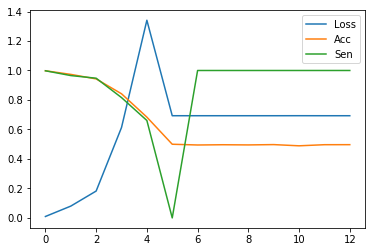

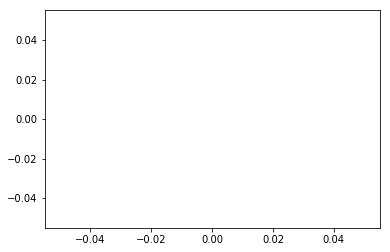

In [34]:
plt.plot(snr,gloss, label="Loss")
plt.plot(snr,gacc, label="Acc")
plt.plot(snr,gsen, label="Sen")
plt.legend()
plt.figure()
plt.plot(snr,gstep, label="Sen")
